In [2]:
import torch
from matplotlib.pyplot import imshow

from importlib import reload
import f#;reload(f)
import eff_net#;reload(eff_net)
F = f.f_gm(7).cuda()
F2 = f.f_gm(7).cuda()

x = torch.rand(1,3,7,7).cuda()

p,v = F(x)

#imshow(x.squeeze(0).permute(1,2,0).detach())
#py = mb2(mb1(x))
True

True

In [16]:
import numpy as np
probs = p[0].cpu().detach().numpy()
A = range(len(probs))
%timeit np.random.choice(A,p=probs)


112 µs ± 9.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [72]:
p.sum(),v
pi,z = p,v
print(bp.shape)
rp = torch.softmax( torch.rand(1,30),1 )*.9
rp2 = torch.softmax( torch.rand(1,19),1 )*.1
rp = torch.cat( [rp, rp2], 1)

bp = torch.cat([p,p,p],0)
bpi = torch.cat([pi,pi,pi],0)
brp = torch.cat([rp,rp,rp],0)
#log(p) is cross entropy. sum( klog(p) ) is what we are doing
# Does this work with multiple batches
def ploss(p, pi): 
    ''' Given input of p, pi of (b,K*K) will compute the batched loss
    '''
    loss = - torch.bmm( pi.unsqueeze(1), torch.log(p.unsqueeze(2))  )
    return loss.sum()

print(brp.shape, bpi.shape, bp.shape)
ploss(brp,bpi), ploss(bp,bpi)


torch.Size([3, 49])
torch.Size([3, 49]) torch.Size([3, 49]) torch.Size([3, 49])


(tensor(12.5451, grad_fn=<SumBackward0>),
 tensor(11.4792, grad_fn=<SumBackward0>))

In [69]:
p.unsqueeze(2).T.shape

torch.Size([1, 49, 1])

In [ ]:
### py.shape
imshow(py[0,6].detach())

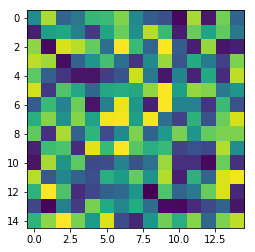

In [5]:
imshow(x[0,0].detach())

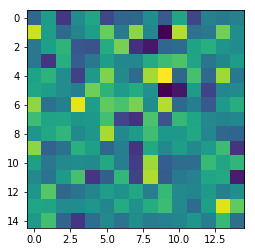

In [8]:

imshow(py[0,3].detach())

In [ ]:
import torchvision
#D = torchvision.datasets.FashionMNIST('data_fshnmnist')
D = torchvision.datasets.CIFAR10('cifar', download=True)

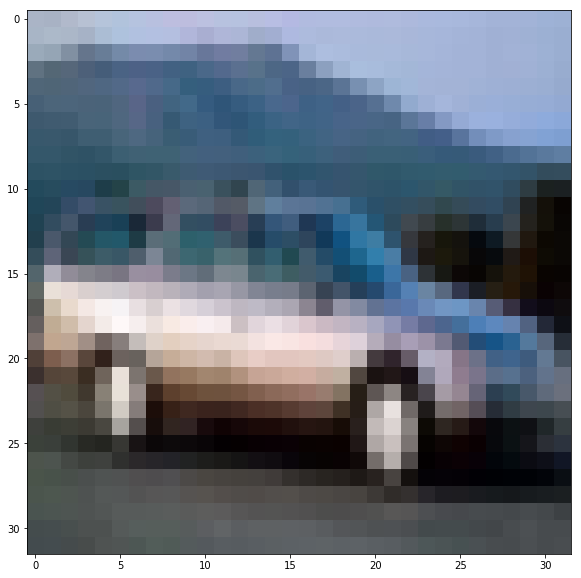

In [27]:
from importlib import reload
import util;reload(util)
util.imshow( D[4][0] )

In [55]:
from torch import nn
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
input, target
#output.backward()

(tensor([[-0.6733, -1.6661,  0.8825,  0.0327,  0.9264],
         [ 0.1476,  2.2089,  1.2471, -0.4444, -1.5490],
         [ 0.9312,  1.1193,  0.6725,  0.3803,  1.4424]], requires_grad=True),
 torch.Size([3]))

In [59]:
torch.IntTensor([4])

tensor([4], dtype=torch.int32)

In [3]:
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch
import numpy as np

class torchdataset(Dataset):

    def __init__(self, tv_dataset):
        self.dataset = tv_dataset
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, i):
        x,y = self.dataset[i]
        x = np.array(x)
        #x = torch.FloatTensor(x).permute(2,0,1)/255
        x = torch.FloatTensor(x)/255
        x = torch.stack([x,x,x])
        y = torch.LongTensor([y])
        return {'x':x, 'y':y}

    
D = torchvision.datasets.CIFAR10('cifar')
D = torchvision.datasets.FashionMNIST('data')
D = torchdataset(D)
trn_dataloader = DataLoader(D, batch_size=25, shuffle=True)
from f import f_gm
#model = f_gm(K=28).cuda()
import torchvision.models as models
#model = models.resnet18(10).cuda()

In [4]:
from eff_net import MBblock
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch
import numpy as np
from torch import nn

class cifar_effnet(nn.Module):
    def __init__(self):
        super(cifar_effnet, self).__init__()
        sqzex = True
        self.b1 = MBblock(3,256,sqzex=sqzex, residual=False)
        B = nn.ModuleList()
        for i in range(3):
            B.append( MBblock(256,256, sqzex=sqzex))
            B.append( MBblock(256,256, strd=2,sqzex=sqzex,residual=False))
        self.B = B
        
        
        self.FC1 = nn.Linear(256*4*4, 256)
        self.FC2 = nn.Linear(256,10)
        
    def forward(self,x):
        B = x.shape[0]
        x = self.b1(x)
        for b in self.B:
            x = b(x)
        x = x.reshape(B,-1)
        x = self.FC1(x)
        x = self.FC2(x)
        
        return x

#x = D[0]['x'].unsqueeze(0)
model = cifar_effnet().cuda()
#model.eval()
#model(x).shape
    
        

In [6]:
from torch import nn
from torch.optim import Adam
loss = nn.CrossEntropyLoss()
optimizer = Adam( model.parameters(), lr=.002, betas=(0.5,0.999), eps=1e-04) 

E,B = 12, len(trn_dataloader)
for e in range(E):
    for b, batch in enumerate(trn_dataloader):
        optimizer.zero_grad()
        x,y = batch['x'], batch['y'].squeeze(1)
        x,y = x.cuda(), y.cuda()
        #py,_ = model(x)
        py = model(x)
        l = loss(py,y)
        l.backward()
        optimizer.step()
        if b%(B//30)==0: print('E',e,'B',b,'loss:',l.item())


E 0 B 0 loss: 2.3363640308380127
E 0 B 80 loss: 0.8201627135276794
E 0 B 160 loss: 0.5386816263198853
E 0 B 240 loss: 0.8103880286216736
E 0 B 320 loss: 0.6749492883682251
E 0 B 400 loss: 0.8029654026031494
E 0 B 480 loss: 0.7363011837005615
E 0 B 560 loss: 0.5522714257240295
E 0 B 640 loss: 0.306724488735199


KeyboardInterrupt: 

In [9]:

py,_ = model(D[0]['x'].unsqueeze(0))
py.shape

torch.Size([1, 10])